## Imports

In [1]:
from pathlib import Path

import os
import torch
import skorch
import numpy as np
import pandas as pd
from skorch.callbacks import EarlyStopping
from tqdm import tqdm
from matplotlib import pyplot as plt
from time_series_predictor import TimeSeriesPredictor

from src.oze_dataset import OzeEvaluationDataset, OzeNPZDataset, npz_check, OZELoss
from src.model import BenchmarkLSTM

## Construct and configure the time series predictor

In [2]:
tsp = TimeSeriesPredictor(
    BenchmarkLSTM(
        hidden_dim=70,
        num_layers=3
    ),
    early_stopping=EarlyStopping(patience=30),
    lr=1e-2,
    max_epochs=500,
    train_split=skorch.dataset.CVSplit(5),
    optimizer=torch.optim.Adam,
    criterion=torch.nn.MSELoss    # OZELoss(alpha=0.3)
)

## Load the dataset

In [3]:
labels_path = os.path.join('src', 'oze_dataset', 'labels.json')
dataset = OzeNPZDataset(
    dataset_path=npz_check(
        Path('datasets'),
        'dataset'
    ),
    labels_path=labels_path
)

## Train the benchmark

In [4]:
tsp.fit(dataset)

Using device cuda
Re-initializing module because the following parameters were re-set: input_dim, output_dim.
Re-initializing optimizer.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0434        0.0170  8.7890
      2        0.0152        0.0142  8.0340
      3        0.0130        0.0130  8.0101
      4        0.0095        0.0077  7.9516
      5        0.0070        0.0064  7.9584
      6        0.0078        0.0084  9.8660
      7        0.0067        0.0055  8.4820
      8        0.0082        0.0061  7.8533
      9        0.0053        0.0047  7.8673
     10        0.0045        0.0042  7.9539
     11        0.0041        0.0042  7.9814
     12        0.0040        0.0036  8.0435
     13        0.0042        0.0036  8.1354
     14        0.0035        0.0033  8.1533
     15        0.0032        0.0029  8.1583
     16        0.0030        0.0027  8.2572
     17        0.0029        0.0027  8.2787
     18        0.0026      

## Plot training evolution

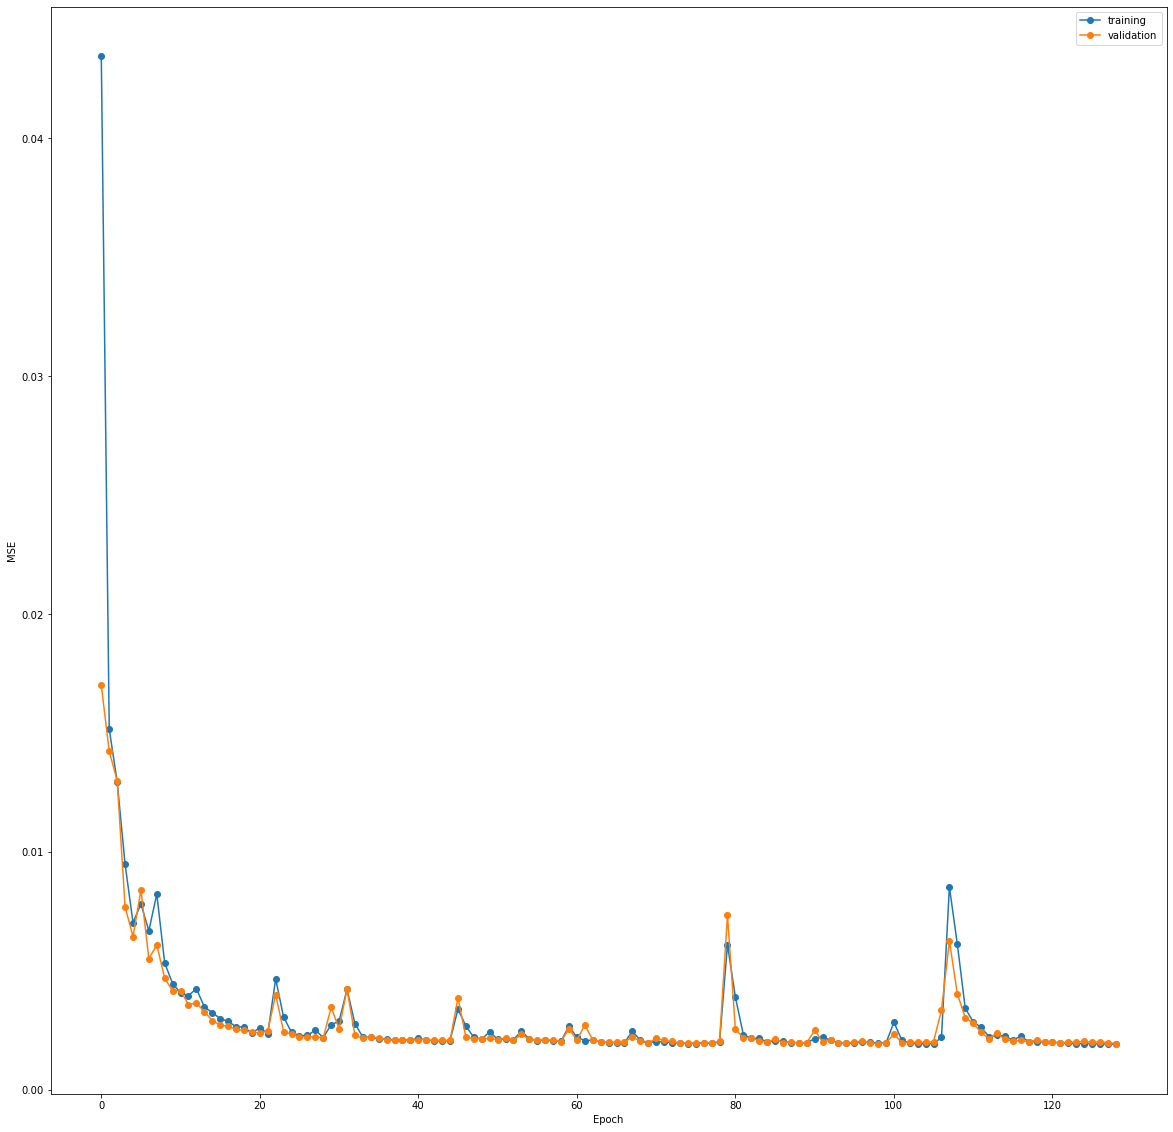

In [5]:
train_loss = tsp.ttr.regressor_['regressor'].history[:, 'train_loss']
valid_loss = tsp.ttr.regressor_['regressor'].history[:, 'valid_loss']
plt.figure(figsize=(20, 20))
plt.plot(train_loss, 'o-', label='training')
plt.plot(valid_loss, 'o-', label='validation')
axes = plt.axes()
axes.set_xlabel('Epoch')
axes.set_ylabel('MSE')
plt.legend()

### Plot the results for a training example

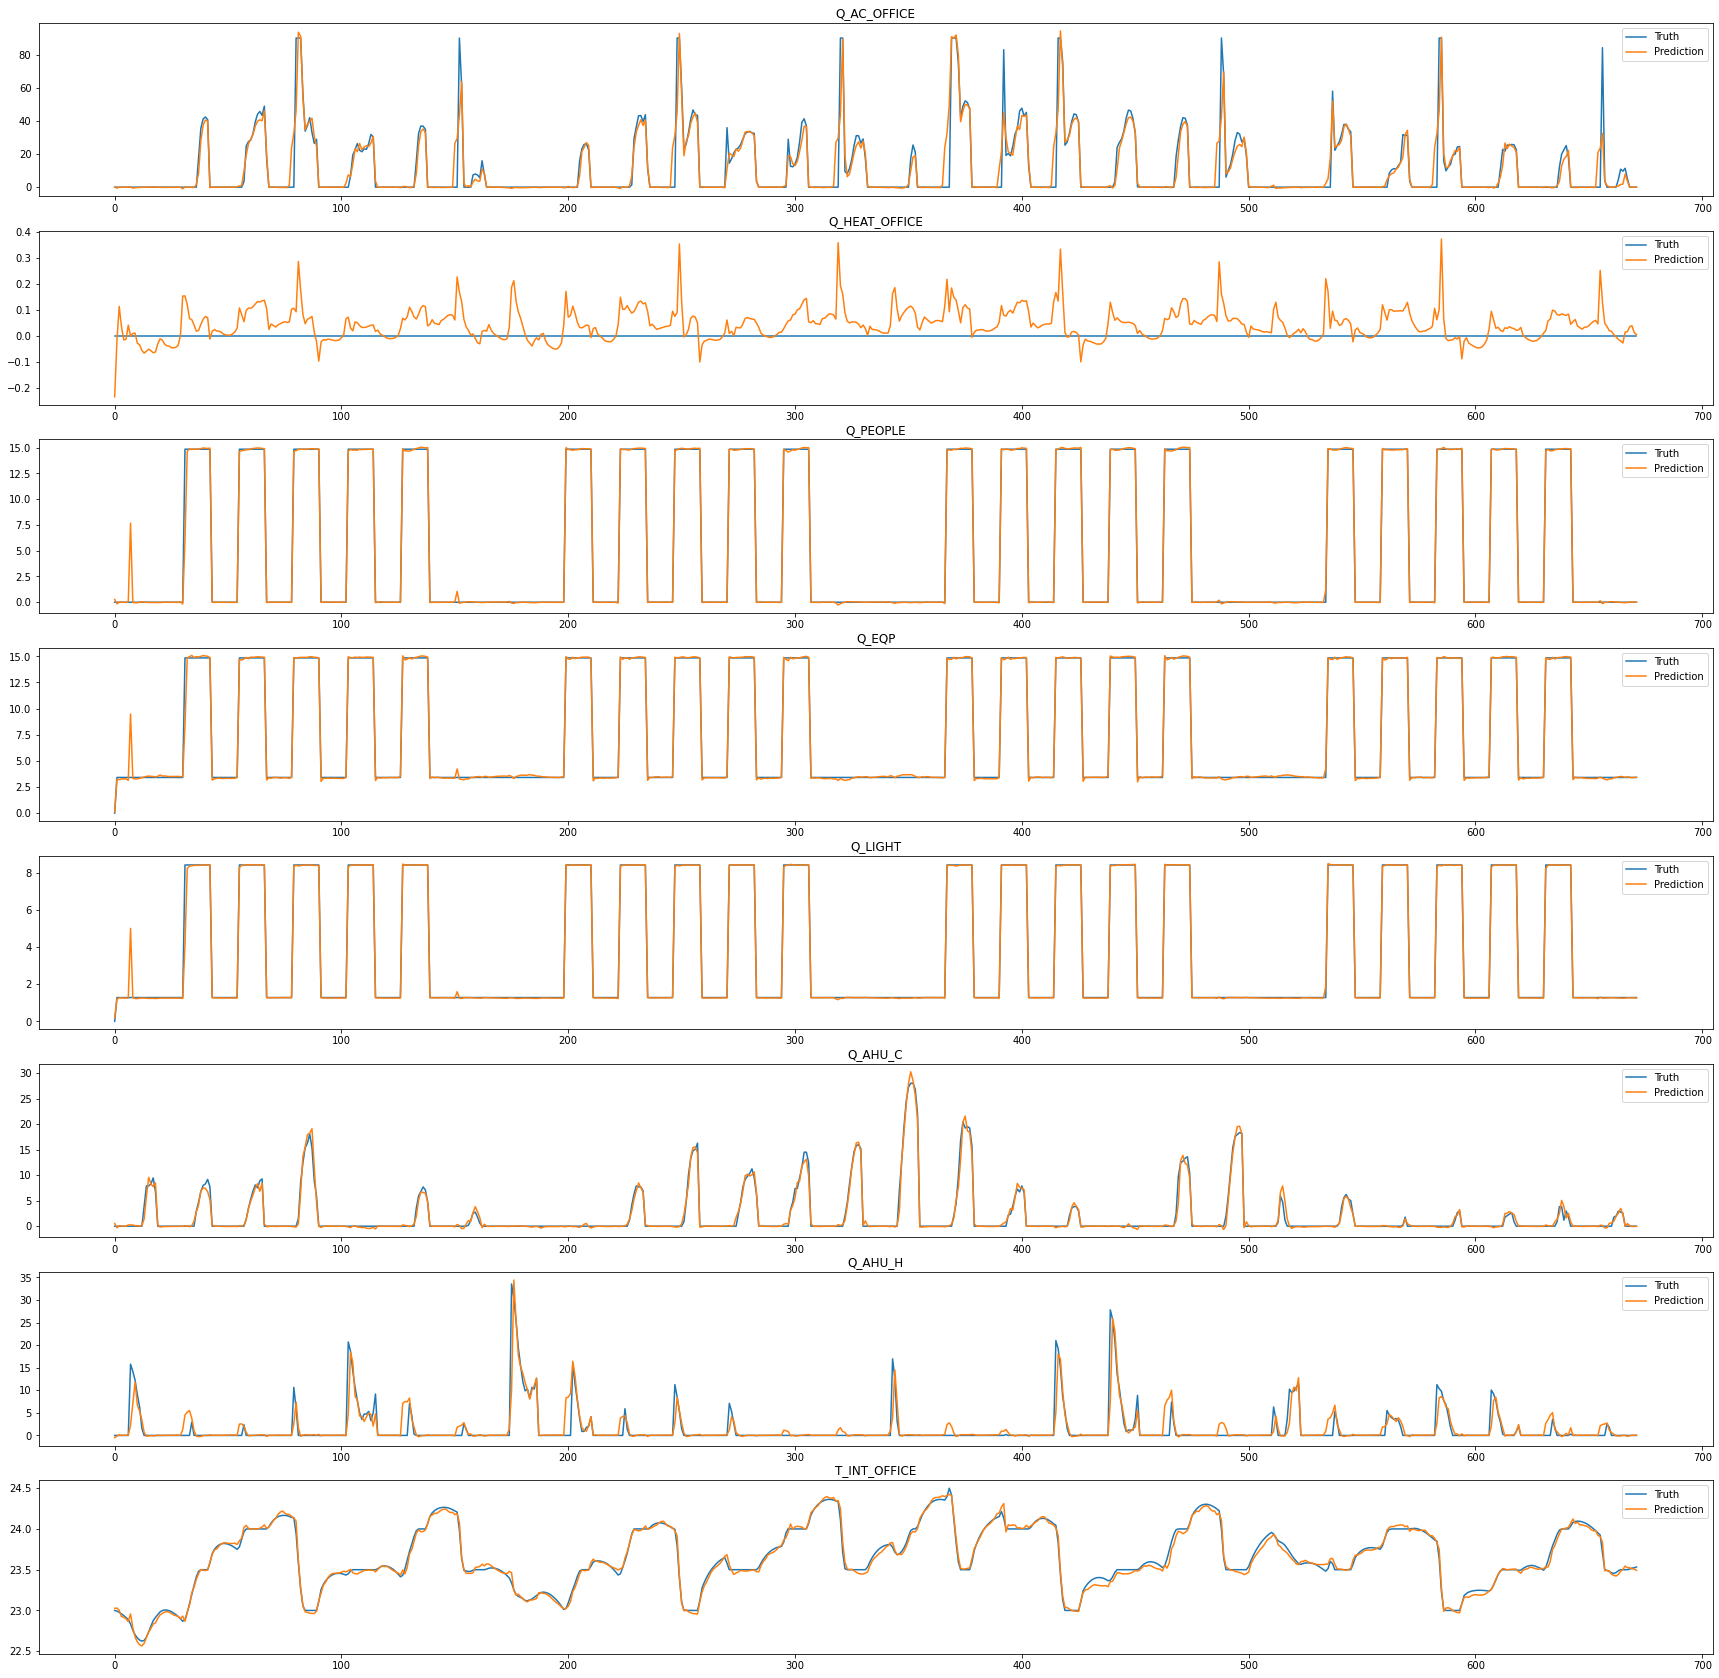

In [6]:
# Select training example
idx = np.random.randint(0, len(tsp.dataset))
dataloader = tsp.ttr.regressor['regressor'].get_iterator(tsp.dataset)
x, y = dataloader.dataset[idx]

# Run predictions
netout = tsp.sample_predict(x)

d_output = netout.shape[1]
plt.figure(figsize=(30, 30))
for idx_output_var in range(d_output):
    # Select real temperature
    y_true = y[:, idx_output_var]

    y_pred = netout[:, idx_output_var]

    plt.subplot(d_output, 1, idx_output_var+1)
    
    plt.plot(y_true, label="Truth")
    plt.plot(y_pred, label="Prediction")
    plt.title(dataloader.dataset.labels["X"][idx_output_var])
    plt.legend()
plt.savefig("fig")

# Evaluation

### Load evaluation dataset

In [7]:
K=tsp.dataset.get_x_shape()[1]
dataset_eval = OzeEvaluationDataset(
    os.path.join('datasets', 'x_test_QK7dVsy.csv'),
    K,
    labels_path=labels_path
)
dataset_eval_length = len(dataset_eval)

### Run prediction

In [8]:
predictions = tsp.predict(dataset_eval.x)

### Export as csv

In [9]:
lines_output = predictions.reshape((dataset_eval_length, -1))
csv_header = [f"{var_name}_{k}" for var_name in dataset_eval.labels['X'] for k in range(K)]

df = pd.DataFrame(lines_output, columns=csv_header)
df.insert(0, 'index', df.index + len(dataset))
df.to_csv('y_bench.csv', index=False)